In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ECHR_Corpus.json to ECHR_Corpus.json


In [ ]:
import json

with open("ECHR_Corpus.json", "r", encoding="utf-8") as f:
    data = json.load(f)


In [ ]:
# Chunk 1: Install dependencies and imports
!pip install transformers torch scikit-learn seaborn matplotlib tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:

import json
import torch
from torch.utils.data import Dataset
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

print("✅ All imports successful!")

✅ All imports successful!


In [ ]:
class LegalClauseDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=256):  # Increased max_length
        with open(file_path, 'r', encoding='utf-8') as f:  # Added encoding
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]

        # Ensure text is not empty
        if not text or not text.strip():
            text = "[EMPTY]"

        encoded = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Label mapping
LABELS = {
    "non-argument": 0,
    "premise": 1,
    "conclusion": 2
}

print("✅ Dataset class and labels defined!")

✅ Dataset class and labels defined!


In [ ]:
def convert_json(input_path, output_train="train.json", output_val="val.json", output_test="test.json", val_size=0.15, test_size=0.15):
    data = []
    seen_texts = set()  # For deduplication

    with open(input_path, "r", encoding="utf-8") as f:
        corpus = json.load(f)

    if isinstance(corpus, dict):
        files = [corpus]
    elif isinstance(corpus, list):
        files = corpus
    else:
        raise ValueError("Input JSON must be a dict or list of dicts.")

    for file_idx, file in enumerate(tqdm(files, desc="Processing files")):
        try:
            full_text = file["text"]
            clause_map = {clause["_id"]: full_text[clause["start"]:clause["end"]].strip() for clause in file["clauses"]}
            all_ids = set(clause_map.keys())

            # FIXED: Handle the actual 'arguments' field structure
            conclusion_ids = set()
            premise_ids = set()

            arguments = file.get("arguments", [])
            if arguments:
                for arg in arguments:
                    # Extract conclusion
                    if "conclusion" in arg:
                        conclusion = arg["conclusion"]
                        if isinstance(conclusion, str):
                            conclusion_ids.add(conclusion)
                        elif isinstance(conclusion, list):
                            conclusion_ids.update(conclusion)

                    # Extract premises
                    if "premises" in arg:
                        premises = arg["premises"]
                        if isinstance(premises, list):
                            premise_ids.update(premises)
                        elif isinstance(premises, str):
                            premise_ids.add(premises)

            non_argument_ids = all_ids - conclusion_ids - premise_ids

            for cid in all_ids:
                label = (
                    LABELS["conclusion"] if cid in conclusion_ids else
                    LABELS["premise"] if cid in premise_ids else
                    LABELS["non-argument"]
                )
                clause_text = clause_map[cid]
                if clause_text and len(clause_text) > 5:  # Filter very short texts
                    # Deduplication check
                    text_hash = hash(clause_text)
                    if text_hash not in seen_texts:
                        seen_texts.add(text_hash)
                        data.append({"text": clause_text, "label": label, "doc_id": file_idx})
        except Exception as e:
            print(f"Error processing document {file_idx}: {e}")
            continue

    # Print label distribution before splitting
    label_counts = {}
    for item in data:
        label = item["label"]
        label_counts[label] = label_counts.get(label, 0) + 1

    print(f"Label distribution in full dataset:")
    for label, count in label_counts.items():
        label_name = [k for k, v in LABELS.items() if v == label][0]
        print(f"  {label_name}: {count} ({count/len(data)*100:.1f}%)")

    # Remove doc_id for clean data
    clean_data = [{"text": item["text"], "label": item["label"]} for item in data]

    # FIXED: Document-based splitting to prevent leakage
    from collections import defaultdict
    doc_groups = defaultdict(list)
    for item in data:
        doc_groups[item["doc_id"]].append({"text": item["text"], "label": item["label"]})

    doc_ids = list(doc_groups.keys())

    if len(doc_ids) >= 3:
        # Split by documents
        train_docs, temp_docs = train_test_split(doc_ids, test_size=(val_size + test_size), random_state=42)
        val_docs, test_docs = train_test_split(temp_docs, test_size=test_size/(val_size + test_size), random_state=42)

        train_data = []
        val_data = []
        test_data = []

        for doc_id in train_docs:
            train_data.extend(doc_groups[doc_id])
        for doc_id in val_docs:
            val_data.extend(doc_groups[doc_id])
        for doc_id in test_docs:
            test_data.extend(doc_groups[doc_id])
    else:
        # Fallback to stratified split
        min_samples = min(label_counts.values())
        if min_samples < 2:
            print("⚠️  Warning: Some classes have very few samples. Using random split instead of stratified.")
            train_data, temp_data = train_test_split(clean_data, test_size=(val_size + test_size), random_state=42)
            val_data, test_data = train_test_split(temp_data, test_size=test_size/(val_size + test_size), random_state=42)
        else:
            train_data, temp_data = train_test_split(clean_data, test_size=(val_size + test_size), random_state=42, stratify=[d["label"] for d in clean_data])
            val_data, test_data = train_test_split(temp_data, test_size=test_size/(val_size + test_size), random_state=42, stratify=[d["label"] for d in temp_data])

    # Save
    with open(output_train, "w", encoding="utf-8") as f:
        json.dump(train_data, f, indent=2)
    with open(output_val, "w", encoding="utf-8") as f:
        json.dump(val_data, f, indent=2)
    with open(output_test, "w", encoding="utf-8") as f:
        json.dump(test_data, f, indent=2)

    print(f"✅ Done! Saved {len(train_data)} train, {len(val_data)} val, {len(test_data)} test examples.")
    return train_data, val_data, test_data

print("✅ Data processing function defined!")

✅ Data processing function defined!


In [ ]:
# Initialize model and tokenizer
model_name = "roberta-base"
print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
print("✅ Model and tokenizer loaded!")

# Process data (make sure ECHR_Corpus.json is uploaded to Colab first)
print("Processing ECHR_Corpus.json...")
train_data, val_data, test_data = convert_json("ECHR_Corpus.json")

# Create datasets
print("Creating datasets...")
train_dataset = LegalClauseDataset("train.json", tokenizer)
val_dataset = LegalClauseDataset("val.json", tokenizer)
test_dataset = LegalClauseDataset("test.json", tokenizer)

print(f"✅ Created datasets:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

Loading roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded!
Processing ECHR_Corpus.json...


Processing files: 100%|██████████| 42/42 [00:00<00:00, 2570.79it/s]

Label distribution in full dataset:
  non-argument: 7252 (76.7%)
  conclusion: 520 (5.5%)
  premise: 1681 (17.8%)
✅ Done! Saved 7527 train, 884 val, 1042 test examples.
Creating datasets...
✅ Created datasets:
  Train: 7527 samples
  Val: 884 samples
  Test: 1042 samples


In [30]:

# Chunk 5: Training configuration
def compute_metrics(eval_pred):
    """Custom metrics function for training"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Modify your training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Increase epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Use macro F1 instead of accuracy
    greater_is_better=True,
    learning_rate=2e-5,  # Try different learning rates
)
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add custom metrics
)

print("✅ Training setup complete!")

✅ Training setup complete!


/tmp/ipython-input-30-1384613865.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
# Chunk 6: Train the model
print("🚀 Starting training...")
trainer.train()
trainer.save_model("./legal-argument-classifier")
print("✅ Training complete and model saved!")

🚀 Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.252100,0.636076,0.824661,0.835368,0.855672,0.824661
1000,0.308200,0.404875,0.840498,0.842585,0.845081,0.840498


✅ Training complete and model saved!


In [32]:
# Chunk 7: Evaluation functions
# Label mapping for evaluation
label_map = ["non-argument", "premise", "conclusion"]

def classify_from_test(model, tokenizer, test_file="test.json", count=5):
    """Test the model on sample examples"""
    with open(test_file, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    # Sample from each class if possible
    sampled = []
    for label_idx in range(3):
        class_examples = [ex for ex in test_data if ex["label"] == label_idx]
        if class_examples:
            sampled.extend(random.sample(class_examples, min(2, len(class_examples))))

    # Fill remaining slots randomly if needed
    remaining = count - len(sampled)
    if remaining > 0:
        remaining_examples = [ex for ex in test_data if ex not in sampled]
        sampled.extend(random.sample(remaining_examples, min(remaining, len(remaining_examples))))

    model.eval()
    results = []

    for entry in sampled:
        text = entry["text"]
        true_label = entry["label"]

        # Tokenize and classify
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        if torch.cuda.is_available():
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0][predicted_class].item()

        results.append({
            "text": text[:100] + "..." if len(text) > 100 else text,  # Truncate long text
            "true_label": label_map[true_label],
            "predicted_label": label_map[predicted_class],
            "confidence": round(confidence, 3)
        })

    return results

def evaluate_model(model, tokenizer, test_dataset):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    device = next(model.parameters()).device

    for item in tqdm(test_dataset, desc="Evaluating"):
        input_ids = item["input_ids"].unsqueeze(0).to(device)
        attention_mask = item["attention_mask"].unsqueeze(0).to(device)
        label = item["labels"].item()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_label = torch.argmax(outputs.logits, dim=1).item()

        all_preds.append(pred_label)
        all_labels.append(label)

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    f1_macro = precision_recall_fscore_support(all_labels, all_preds, average='macro')[2]

    print("\n✅ Evaluation Metrics:")
    print(f"Accuracy      : {acc:.4f}")
    print(f"F1 (weighted) : {f1:.4f}")
    print(f"F1 (macro)    : {f1_macro:.4f}")

    print("\n📄 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_map))

    # Check prediction distribution
    pred_counts = {}
    for pred in all_preds:
        pred_counts[pred] = pred_counts.get(pred, 0) + 1

    print("\n🔍 Prediction Distribution:")
    for label_idx, count in pred_counts.items():
        print(f"  {label_map[label_idx]}: {count} ({count/len(all_preds)*100:.1f}%)")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map, yticklabels=label_map)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return all_preds, all_labels

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!



🔍 Testing on sample examples:

🔹 Example 1
Text             : In their memorial the Government asked the Court
True Label       : non-argument
Predicted Label  : non-argument
Confidence       : 0.986

🔹 Example 2
Text             : Hale's proposition reflected the state of affairs in those respects at the time it was enunciated.
True Label       : non-argument
Predicted Label  : non-argument
Confidence       : 0.996

🔹 Example 3
Text             : The Court considers that the present proceedings can clearly be distinguished from the custody proce...
True Label       : premise
Predicted Label  : premise
Confidence       : 0.652

🔹 Example 4
Text             : The Court notes that Mr Gradinger based his complaints on Article 6 (art. 6) of the Convention, wher...
True Label       : premise
Predicted Label  : premise
Confidence       : 0.964

🔹 Example 5
Text             : It follows that this complaint is manifestly ill-founded within
the meaning of Article 27 para. 2 (...
True Label    

Evaluating: 100%|██████████| 1042/1042 [00:16<00:00, 64.35it/s]



✅ Evaluation Metrics:
Accuracy      : 0.7831
F1 (weighted) : 0.7867
F1 (macro)    : 0.6344

📄 Classification Report:
              precision    recall  f1-score   support

non-argument       0.88      0.86      0.87       790
     premise       0.50      0.59      0.54       194
  conclusion       0.55      0.45      0.50        58

    accuracy                           0.78      1042
   macro avg       0.64      0.63      0.63      1042
weighted avg       0.79      0.78      0.79      1042


🔍 Prediction Distribution:
  non-argument: 766 (73.5%)
  premise: 229 (22.0%)
  conclusion: 47 (4.5%)


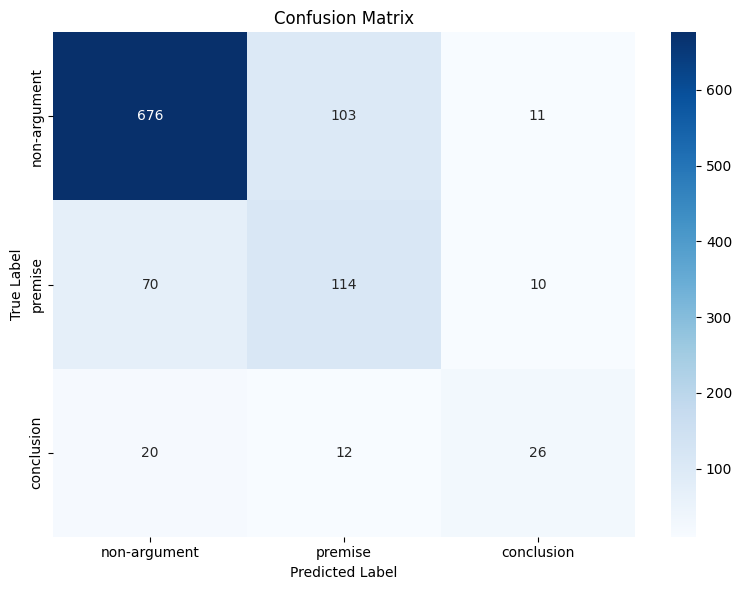

In [33]:
# Chunk 8: Run evaluation
print("\n🔍 Testing on sample examples:")
examples = classify_from_test(model, tokenizer, count=6)
for i, ex in enumerate(examples, 1):
    print(f"\n🔹 Example {i}")
    print(f"Text             : {ex['text']}")
    print(f"True Label       : {ex['true_label']}")
    print(f"Predicted Label  : {ex['predicted_label']}")
    print(f"Confidence       : {ex['confidence']}")

print("\n" + "="*50)
print("🔍 Full model evaluation:")
predictions, labels = evaluate_model(model, tokenizer, test_dataset)